# Import necessray libraries

In [61]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix,roc_curve, auc, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from itertools import cycle
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.model_selection import GridSearchCV
from dataprep.eda import create_report
from sklearn.svm import SVC
import numpy as np
from sklearn.model_selection import LeavePGroupsOut
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.neural_network import MLPClassifier

# Functions

In [62]:
def train_test_split_per_user(data, train_size=0.7, target_column='label_negative_affect_category'):
    users = list(set(data.user_id))
    users = sorted(users, reverse=True)
    total_users = len(users)
    slice_idx = int(train_size * total_users)
    users_train = users[:slice_idx]
    users_test = users[slice_idx:]

    # Split data based on user IDs
    train_data = data[data.user_id.isin(users_train)]
    test_data = data[data.user_id.isin(users_test)]

    x_train = train_data.drop(['user_id', target_column], axis=1)
    y_train = train_data[target_column]
    x_test = test_data.drop(['user_id', target_column], axis=1)
    y_test = test_data[target_column]

    return x_train, y_train, x_test, y_test

In [63]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()

# Read the data

In [64]:
df = pd.read_pickle("../data/depresjon/depresjon_preprocessed.pkl")
df = df[df['category_madrs'].notna()]
df.head()

,user_id,activity,days,gender,age,afftype,melanch,inpatient,edu,marriage,...,month_sin,weekday_sin,week_sin,day_sin,month_cos,weekday_cos,week_cos,day_cos,activity_quantile,user_activity_quantile
0,1,174.144444,11,2,1,2.0,2.0,2.0,1,1.0,...,-0.974928,0.974928,-0.998027,0.988468,-0.222521,-0.222521,0.062791,0.151428,1,1
1,1,156.247222,11,2,1,2.0,2.0,2.0,1,1.0,...,-0.974928,0.433884,-0.998027,0.998717,-0.222521,-0.900969,0.062791,-0.050649,1,1
2,1,124.135417,11,2,1,2.0,2.0,2.0,1,1.0,...,-0.974928,-0.433884,-0.998027,0.968077,-0.222521,-0.900969,0.062791,-0.250653,1,1
3,1,134.961806,11,2,1,2.0,2.0,2.0,1,1.0,...,-0.974928,-0.974928,-0.998027,0.897805,-0.222521,-0.222521,0.062791,-0.440394,1,1
4,1,99.439583,11,2,1,2.0,2.0,2.0,1,1.0,...,-0.974928,-0.781831,-0.998027,0.790776,-0.222521,0.623490,0.062791,-0.612106,1,0


In [65]:
df.columns

Index(['user_id', 'activity', 'days', 'gender', 'age', 'afftype', 'melanch',
       'inpatient', 'edu', 'marriage', 'work', 'is_weekend', 'category_madrs',
       'month_sin', 'weekday_sin', 'week_sin', 'day_sin', 'month_cos',
       'weekday_cos', 'week_cos', 'day_cos', 'activity_quantile',
       'user_activity_quantile'],
      dtype='object')

In [66]:
df['category_madrs'].value_counts()

0    201
1    188
Name: category_madrs, dtype: int64

# Generic model
each user belongs to either the train or the test set

In [35]:
X_train, y_train, X_test, y_test = train_test_split_per_user(df,target_column='category_madrs')

In [36]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(264, 21) (264,) (125, 21) (125,)


In [37]:
#clf = RandomForestClassifier(n_estimators=100, random_state=42)
#clf = XGBClassifier(n_estimators=100, random_state=42)
clf = GradientBoostingClassifier(n_estimators=160, learning_rate=0.3, random_state=42)

In [38]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

f1 = f1_score(y_test, y_pred, average='micro')
print(f"F1 Score: {f1}")
print(confusion_matrix(y_test, y_pred))

F1 Score: 0.256
[[16 32]
 [61 16]]


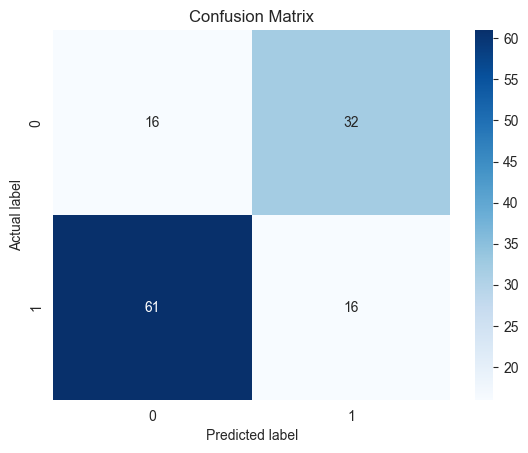

In [39]:
plot_confusion_matrix(y_test, y_pred)

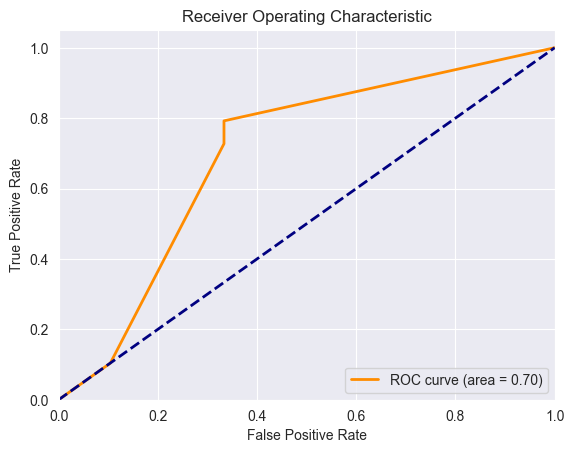

In [40]:
# Predict probabilities
y_scores = clf.predict_proba(X_test)[:, 0]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Leave one person out (LOPO) method

In [41]:
X = df.drop(['category_madrs', 'user_id'], axis=1)  # Features
y = df['category_madrs']  # Target variable
unique_labels = y.unique()
groups = df['user_id']  # Group identifier for LOPO

#model = RandomForestClassifier(n_estimators=100, random_state=42)
#model = XGBClassifier(n_estimators=100)
model = GradientBoostingClassifier(n_estimators=160, learning_rate=0.3, random_state=42)

cv = LeavePGroupsOut(n_groups=1)
scores = []
confusion_matrices = []

for train_idx, test_idx in cv.split(X, y, groups):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = f1_score(y_test, y_pred, average='micro')
    scores.append(score)
    cm = confusion_matrix(y_test, y_pred, labels=unique_labels)
    confusion_matrices.append(cm)

# Calculate the average performance across all LOPO iterations
average_score = np.mean(scores)
print(f'Average f1-scores across all LOPO iterations: {average_score}')
total_confusion_matrix = np.sum(confusion_matrices, axis=0)
print(total_confusion_matrix)

Average f1-scores across all LOPO iterations: 0.40574866310160423
[[ 26 162]
 [ 80 121]]


# Deep Learning

F1 Score: 0.423728813559322


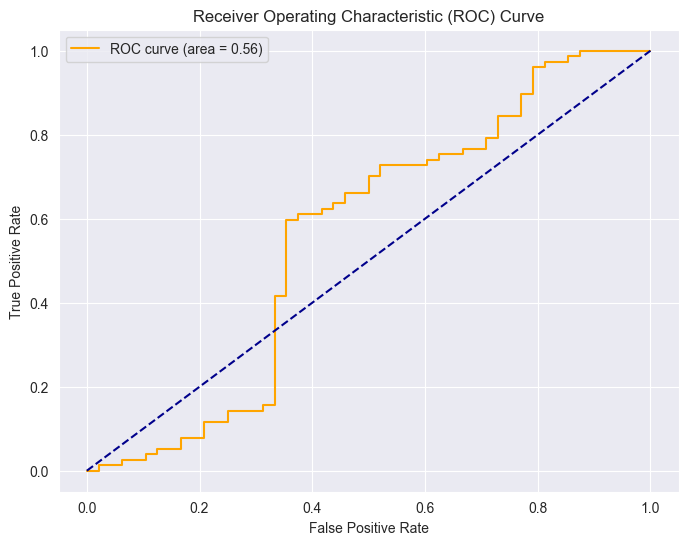

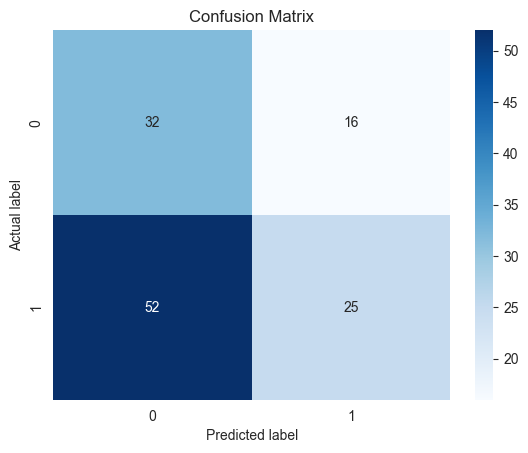

In [98]:
X_train, y_train, X_test, y_test = train_test_split_per_user(df,target_column='category_madrs')

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

#mlp = MLPClassifier(random_state=42, max_iter=800)
mlp = MLPClassifier(max_iter=1000, activation = 'relu', alpha=0.001, hidden_layer_sizes=(50,), random_state=42)
mlp.fit(X_train_smote, y_train_smote)

y_pred = mlp.predict(X_test)
y_pred_proba = mlp.predict_proba(X_test)[:, 1]  # Get probability for the positive class

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Confusion Matrix
plot_confusion_matrix(y_test, y_pred)
plt.show()